# Проект для «Викишоп»

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.  
Постройте модель со значением метрики качества F1 не меньше 0.75. 

## Инструкция для проекта

Решить задачу можно как с помощью BERT, так и без этой нейронки. Если хотите попробовать BERT —

    Выполните проект локально. В тренажере тетрадь Jupyter ограничена 4 ГБ оперативной памяти — для проекта с BERT этого может не хватить.
    Упомяните BERT в заголовке проекта в первой ячейке:

Выполнить проект без BERT можно локально или в нашем тренажёре.
В любом случае алгоритм решения выглядит так:

   1. Загрузите и подготовьте данные.
   2. Обучите разные модели.
   3. Сделайте выводы.

## Описание данных

In [ ]:
Данные находятся в файле /datasets/toxic_comments.csv. 
Столбец text в нём содержит текст комментария, а toxic — целевой признак.

# Решение

### Libs

In [1]:
import pandas as pd
from pymystem3 import Mystem
import re
import time
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
toxic_comments = pd.read_csv('toxic_comments.csv')

In [3]:
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
toxic_comments.query('toxic == 1')

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,Your absurd edits \n\nYour absurd edits on gre...,1
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1


In [5]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
### Проверим соотношения значений целового признака

In [6]:
toxic_comments['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

In [7]:
### Видно явное преобладание комментариев 0 класса, т.е нетоксичных

<AxesSubplot:xlabel='toxic', ylabel='count'>

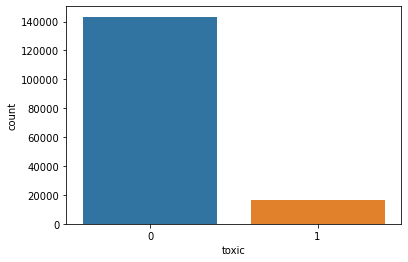

In [8]:
sns.countplot(x='toxic', data=toxic_comments)

In [ ]:
### Проверим дубли

In [9]:
toxic_comments['text'].duplicated().sum()

0

In [10]:
corpus = toxic_comments['text'].values.astype('U')

## TF-IDF на LositicRegression and LightGBM по уменьшенной выборке

In [378]:
### Напишем функции для лематизации и очистки текста от ненужных символов

In [260]:
from nltk.stem import SnowballStemmer

In [261]:
stemmer = SnowballStemmer("english")

In [262]:
def str_stemmer(s):
#     stemmer = SnowballStemmer("english")
    
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [263]:
def clear_text(text):

    text = re.sub(r'[^a-zA-Z]', " ", str(text))
    text_clear = " ".join(text.split())
    
    return text_clear

In [264]:
### Возьмем датасет меньшего размера, из-за ограниченности ресурсов на обучение

In [299]:
data = toxic_comments.sample(80000).reset_index(drop=True)

In [300]:
data['toxic'].value_counts(normalize=True)

0    0.897713
1    0.102288
Name: toxic, dtype: float64

In [301]:
%%time

data['lemmatize_text'] = data['text'].apply(lambda x: str_stemmer(clear_text(x)))

Wall time: 1min 5s


In [268]:
data.head()

,text,toxic,lemmatize_text
0,"Block \n\nBoy, there sure dont block a fella f...",0,block boy there sure dont block a fella for a ...
1,"Well fellow wikipedians, a lot of good images ...",0,well fellow wikipedian a lot of good imag opin...
2,"Pilger \n\nDear BenBen, Christine McKinney did...",0,pilger dear benben christin mckinney did and d...
3,""":::::::::::::::::So what if Konqueror and oth...",0,so what if konqueror and other file manag can ...
4,|decline=Here's your reply. No. :==( o ),0,declin here s your repli no o


In [269]:
#### Разделим датасет на тренировочную и тестовую выборку

In [302]:
### Так как наблюдается сильный дисбаланс классов, то используем аргумент stratify при разделении данных. Он гарантирует, что в новых выборках пропорция классов будет такая же что и в исходном датасете.
train, test = train_test_split(data, test_size=0.25, random_state=2021)

In [303]:
train.shape, test.shape

((60000, 3), (20000, 3))

In [304]:
### Посмотрим соотношения классов на усеченных выборках
train['toxic'].value_counts(normalize=True), test['toxic'].value_counts(normalize=True)

(0    0.896783
 1    0.103217
 Name: toxic, dtype: float64,
 0    0.9005
 1    0.0995
 Name: toxic, dtype: float64)

In [305]:
corpus_train = train['lemmatize_text'].values.astype('U')
corpus_test = test['lemmatize_text'].values.astype('U')

In [306]:
count_tf_idf = TfidfVectorizer(stop_words='english')

In [307]:
### Преобразуем в вектор и обучим тренировочную выборку
train_tf_idf = count_tf_idf.fit_transform(corpus_train)

In [308]:
### Преобразуем в вектор тестовую выборку
test_tf_idf = count_tf_idf.transform(corpus_test)

In [309]:
train_tf_idf.shape, test_tf_idf.shape

((60000, 73408), (20000, 73408))

In [310]:
### Проведем предварительный расчет метрики f1 по нескольким моделям

print('f1 score по усеченной выборке без настройки гиперпараметров: \n')                             

pipelines = []
pipelines.append(('Logit', LogisticRegression(random_state=2021)))
pipelines.append(('LGBM', LGBMClassifier(random_state=2021)))

for name, model in pipelines:
   
    start_time = time.time()
    
    skf = StratifiedKFold(n_splits=10, random_state=2021, shuffle=True)
    f1_cv = cross_val_score(model, 
                            train_tf_idf, 
                            train['toxic'], 
                            cv=skf, 
                            scoring='f1')
    
    end_time = (time.time() - start_time)

    print("%s: %f (ET: %.2fs)" % (name, f1_cv.mean(), end_time))

f1 score по усеченной выборке без настройки гиперпараметров: 

Logit: 0.691850 (ET: 16.31s)
LGBM: 0.749476 (ET: 102.59s)


In [ ]:
### Модель логистической регрессии не дотягивает до целевого значения метрики f1 = 0.75, поэтому попробуем настроить гиперпараметры для нее.
### Модель LGBM показала значение близкое к минимально допустимому. На полном наборе данных возможно метрика будет лучше.

In [70]:
### Проведем настройку параметров для моделей 

### LogisticRegression

In [311]:
import numpy as np

In [312]:
logit = LogisticRegression(                           
                           random_state=2021
                          )

In [313]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2021)

In [314]:
logit_params = {'C': np.logspace(-3, 3, 10),
               'penalty': ['l1', 'l2']}

In [315]:
searcher_logit = GridSearchCV(logit,
                             logit_params,
                             cv=skf,
                             scoring='f1')

In [316]:
%%time

searcher_logit.fit(train_tf_idf, train['toxic'])

Wall time: 2min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2021, shuffle=True),
             estimator=LogisticRegression(random_state=2021),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [317]:
searcher_logit.best_params_

{'C': 46.41588833612773, 'penalty': 'l2'}

In [ ]:
### Расчет с настроенными гиперпараметрами

In [374]:
logit = LogisticRegression(C=10, 
                           penalty='l2', # штрафуем модель за переобучение
                           class_weight='balanced', # Сбалансируем классы
                           solver='liblinear', 
                           random_state=2021
                          )

In [375]:
cv_results = cross_val_score(logit,
                             train_tf_idf,
                             train['toxic'],
                             cv=skf, 
                             scoring='f1')

In [376]:
#### После настройки параметров метрика f1 увеличилась практически на 10%

In [377]:
cv_results.mean()

0.7596624678266688

In [378]:
X_train = train_tf_idf
X_test = test_tf_idf

In [379]:
y_train = train['toxic']
y_test = test['toxic']

In [380]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 73408), (60000,), (20000, 73408), (20000,))

In [381]:
logit.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=2021,
                   solver='liblinear')

In [382]:
y_pred_train = logit.predict(X_train)

In [383]:
y_pred_test = logit.predict(X_test)

In [384]:
print('Метрика f1 на тренировоной выборке = ', f1_score(y_train, y_pred_train))
print('Метрика f1 на тестовой выборке = ', f1_score(y_test, y_pred_test))

Метрика f1 на тренировоной выборке =  0.9246796072847187
Метрика f1 на тестовой выборке =  0.7567818223974031


In [385]:
#### Построим матрицу ошибок

In [386]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(y_test, y_pred_test))

[[17319   691]
 [  358  1632]]


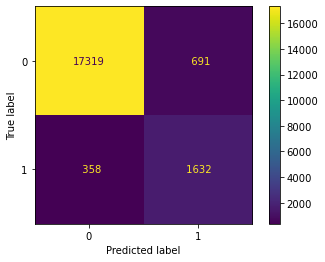

In [387]:
plot_confusion_matrix(logit, X_test, y_test, values_format='5g', cmap=plt.cm.Blues)
plt.show()

In [ ]:
### Наша модель определяет 291 текст как токсичный (в то время как они таковыми не являются), а также 213 текстов как позитивные, в то время как они токсичные. 

### LightGBM

In [252]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [253]:
lgb_model = LGBMClassifier(random_state=2021)

In [ ]:
#### Выполним 2-х этапный поиск гиперпараметров, т.к при таком варианте качество модели получается лучше

In [ ]:
#### 1 этап - настройка сложности модели

In [127]:
# param_test ={'num_leaves': sp_randint(31, 100), 
#              'max_depth': sp_randint(7, 30),
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              }

In [394]:
lgb_params = {'num_leaves': [15, 31, 63],
             'max_depth': [22, 27, 32]}

In [395]:
searcher_lgb = RandomizedSearchCV(lgb_model,
                           lgb_params,
                           cv=skf,
                           scoring='f1',
                           verbose=5, 
                           n_jobs=-1,      
                           random_state=2021)

In [396]:
searcher_lgb.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2021, shuffle=True),
                   estimator=LGBMClassifier(random_state=2021), n_jobs=-1,
                   param_distributions={'max_depth': [22, 27, 32],
                                        'num_leaves': [15, 31, 63]},
                   random_state=2021, scoring='f1', verbose=5)

In [398]:
searcher_lgb.best_params_

{'num_leaves': 31, 'max_depth': 32}

In [136]:
# optim_params = {'max_depth': searcher_lgb.best_params_['max_depth'],
#                'min_child_samples':searcher_lgb.best_params_['min_child_samples'],
#                'min_child_weight': searcher_lgb.best_params_['min_child_weight'],
#                'num_leaves': searcher_lgb.best_params_['num_leaves'],
#                'reg_alpha': searcher_lgb.best_params_['reg_alpha'],
#                'subsample': searcher_lgb.best_params_['subsample']}


In [399]:
searcher_lgb.best_score_

0.7494763809203394

In [ ]:
#### 2 этап - поиск оптимального шага обучения

In [400]:
n_iter = 300

In [401]:
lgb2 = LGBMClassifier(num_leaves=63,
                      max_depth=32,
                      n_estimators=n_iter,
                      metric = 'f1',
                      n_jobs = -1,
#                          bagging_freq = 5,
                      random_state=2021,
#                       is_unbalance = True,
                        )

In [402]:
lgb_learning_rate = {'learning_rate': [0.01, 0.025, 0.05, 0.1]}

In [403]:
searcher_lgb2 = RandomizedSearchCV(lgb2,
                                  lgb_learning_rate,
                                  cv=skf,
                                  scoring='f1',
                                  verbose=5,
                                  n_jobs=-1,
                                  random_state=2021)

In [404]:
searcher_lgb2.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2021, shuffle=True),
                   estimator=LGBMClassifier(max_depth=32, metric='f1',
                                            n_estimators=300, num_leaves=63,
                                            random_state=2021),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.025, 0.05,
                                                          0.1]},
                   random_state=2021, scoring='f1', verbose=5)

In [405]:
searcher_lgb2.best_params_

{'learning_rate': 0.1}

In [406]:
#### Финальный расчет LightGBM.

In [413]:
lgb_final = LGBMClassifier(
                         num_leaves=63,
                         max_depth=32,
                         learning_rate=0.1, 
                         metric ='f1',
                         is_unbalance = True,
                         n_estimators=300,
                         n_jobs = -1,
                         random_state=2021
                        )

In [414]:
lgb_final.fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, max_depth=32, metric='f1', n_estimators=300,
               num_leaves=63, random_state=2021)

In [415]:
y_pred_train = lgb_final.predict(X_train)

In [416]:
y_pred_test = lgb_final.predict(X_test)

In [417]:
print('f1 на тренировочной выборке', f1_score(y_train, y_pred_train))

f1 на тренировочной выборке 0.9375334505696155


In [418]:
print('f1 на тестовой выборке', f1_score(y_test, y_pred_test))

f1 на тестовой выборке 0.7691927919032338


### LGBM без настройки параметров

In [419]:
lgb_f = LGBMClassifier(random_state=2021, metrics='f1')

In [420]:
lgb_f.fit(X_train, y_train)

LGBMClassifier(metrics='f1', random_state=2021)

In [421]:
y_pr = lgb_f.predict(X_test)

In [422]:
f1_score(y_test, y_pr)

0.7595959595959597

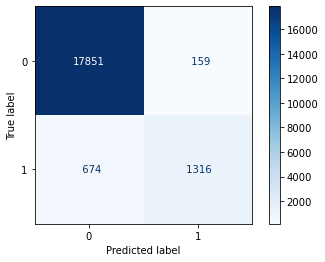

In [423]:
plot_confusion_matrix(lgb_f, X_test, y_test, values_format='5g', cmap=plt.cm.Blues)
plt.show()

### BERT

In [438]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import transformers
import torch
from tqdm import notebook

In [427]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [428]:
# tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

In [429]:
toxic_comments_sample = toxic_comments.sample(400).reset_index(drop=True)

In [431]:
#### truncation=True обрезает предложения до максимально возможной для обучения модели длины - 512
tokenized = toxic_comments_sample['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

In [432]:
tokenized

0      [101, 7014, 23689, 8602, 2106, 3711, 1999, 199...
1      [101, 1000, 2179, 2130, 2062, 3350, 1997, 2454...
2      [101, 15960, 15544, 18376, 2036, 2272, 2000, 2...
3                     [101, 2036, 5868, 2811, 2694, 102]
4      [101, 2008, 2453, 6011, 5399, 3697, 6195, 2028...
                             ...                        
395    [101, 2089, 2289, 1006, 11396, 1007, 1045, 100...
396    [101, 7929, 2031, 7034, 2006, 2831, 3931, 1012...
397    [101, 2748, 1012, 1045, 2359, 2000, 4009, 4568...
398    [101, 2214, 15342, 2030, 2705, 9888, 2339, 210...
399    [101, 1000, 2216, 1000, 1000, 22498, 2015, 100...
Name: text, Length: 400, dtype: object

In [433]:
###Вычислим макимальную длину векторов 

max_len = 0

for v in tokenized.values:
    if len(v) > max_len:
        max_len = len(v)
        
print('Макимальная длина векторов =', max_len)

Макимальная длина векторов = 512


In [434]:
### Здесь добавляем к каждому вектору нулевой вектор, если его размерность меньше максимальной. Это нужно для того, чтобы размерность всех векторов была одинаковая
padded = np.array([v + [0]*(max_len - len(v)) for v in tokenized.values])

In [435]:
## Создаем маску для указания, что 0 значения не значимы в расчете
attention_mask = np.where(padded != 0, 1, 0)

In [436]:
padded.shape, attention_mask.shape

((400, 512), (400, 512))

In [437]:
### Инициализируем класс модели и конфигурацию

config = transformers.BertConfig.from_json_file('bert_config1.json')
model = AutoModel.from_pretrained("bert-base-uncased")
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [439]:
batch_size = 100

embeddings = []

## Строка отражающая прогресс выполнения
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    
    #### Приводим батчи и маску к типу tensor PyTorch (многомерного вектора)
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    ### Градиент не используем
    with torch.no_grad():
        
        ### Создаем эмбеддинги для батчей. Для этого в обученную модель передаем батчи и маску важности признаков
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        ## Добаляем эмбеддинги в формате numpy в список
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [440]:
X = np.concatenate(embeddings)

In [441]:
y = toxic_comments_sample['toxic']

In [442]:
y.value_counts(normalize=True)

0    0.9
1    0.1
Name: toxic, dtype: float64

In [443]:
X.shape, y.shape

((400, 768), (400,))

In [79]:
### Разобъем данные на трейн и тест

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021)

In [445]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((300, 768), (100, 768), (300,), (100,))

In [122]:
#### Обучим логистическую регрессию

In [465]:
logit = LogisticRegression(C=3, 
                           solver='liblinear',
                           penalty = 'l2',
                           class_weight='balanced',
                           random_state=2021)

In [466]:
# logit = LogisticRegression(random_state=2021,
#                           class_weight='balanced')

In [467]:
logit.fit(X_train, y_train)

LogisticRegression(C=3, class_weight='balanced', random_state=2021,
                   solver='liblinear')

In [468]:
y_pred_test_logit = logit.predict(X_test)

In [469]:
f1_score(y_test, y_pred_test_logit)

0.8

#### Вывод: Достичь заявленной точности удалось на модели LositicRegression c настроенными гиперпараметрами и урезанной выборке f1  =  0.7567818223974031.     Модель LightGBM дала точность 0.7691927919032338 без настройки гиперпараметров. Лучший результат получили по BERT с LogisticRegression (для снижения времени обучения были взяты всего 400 примеров), f1 = 0.8.